In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [4]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

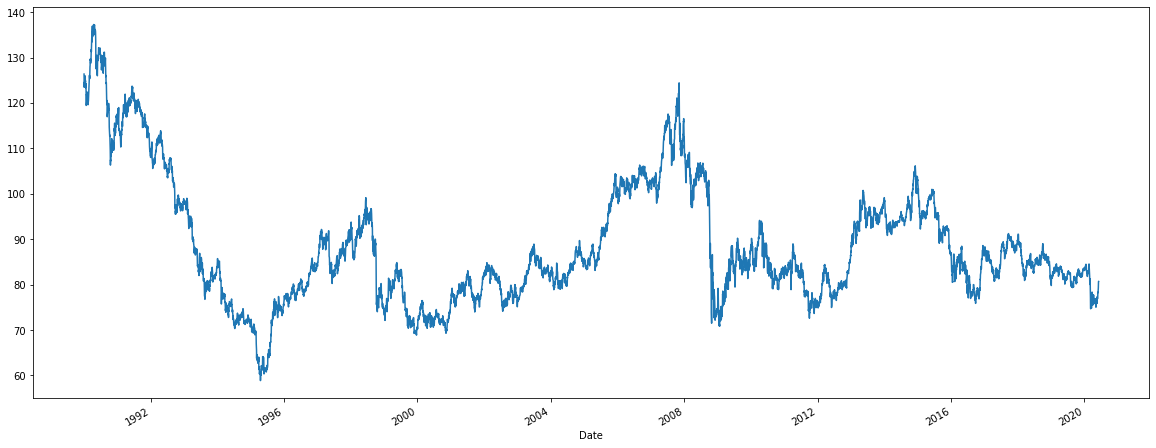

In [11]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize = [20,8])

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** I don't see any obvious patterns, however theres is a long term downwards trend and the effects of previouse world wide recessions can be seen

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [12]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [20]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
df = pd.DataFrame()
df['Price']=cad_jpy_df['Price']
df['noise'] = ts_noise
df['trend'] = ts_trend
df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:xlabel='Date'>

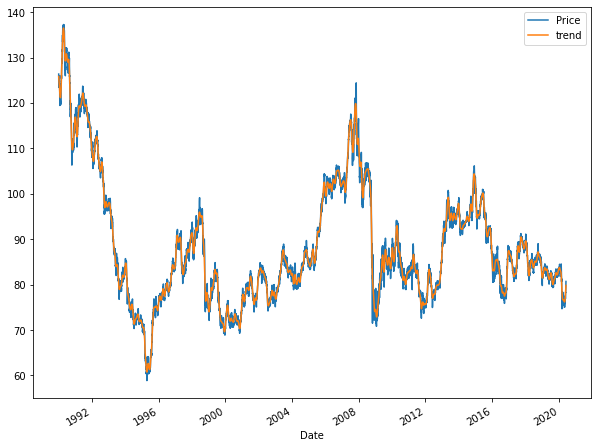

In [19]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
df[['Price','trend']].plot(figsize = [10,8])

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** I see an impact due to the GFC, but generally I see a long term downwards trend

<AxesSubplot:xlabel='Date'>

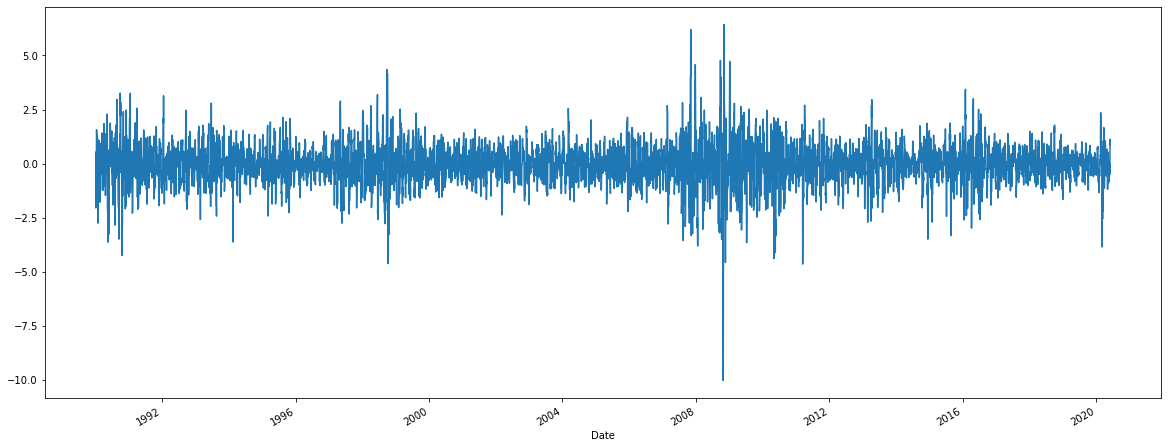

In [21]:
# Plot the Settle Noise
df.noise.plot(figsize=[20,8])

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [22]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [25]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45590D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.60600D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.49720D-04


 This problem is unconstrained.



At iterate   15    f=  1.23008D+00    |proj g|=  2.19582D-03

At iterate   20    f=  1.23007D+00    |proj g|=  1.62981D-05

At iterate   25    f=  1.23007D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   4.441D-08   1.230D+00
  F =   1.2300678291595062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [26]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 02 May 2022   AIC                          19513.955
Time:                        19:22:49   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

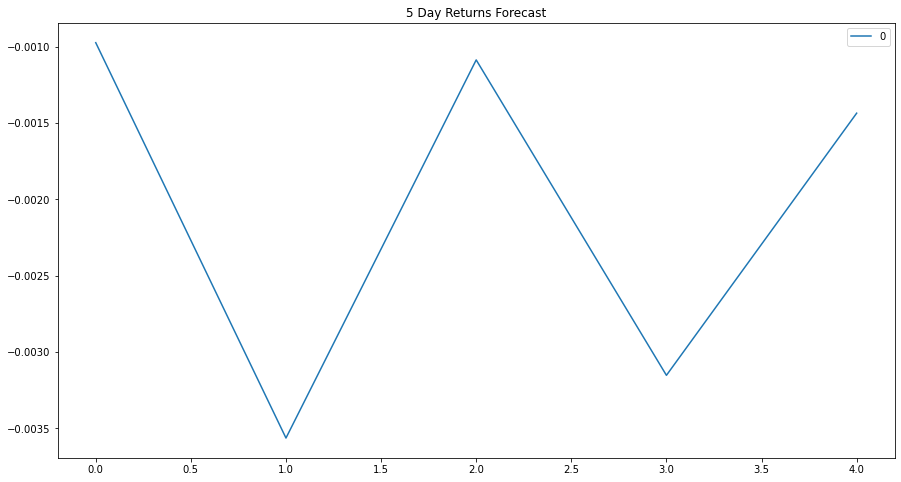

In [28]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast",figsize=(15,8))

**Question:** Based on the p-value, is the model a good fit?

**Answer:** No the P values are much higher then 5% therefore it does not go against the hypothesis.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [30]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arimaModel = ARIMA(returns['Price'], order=(5, 1, 1))
# Fit the model
arimaResults = arimaModel.fit()

/Users/tarikthomas/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tarikthomas/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23246D+00    |proj g|=  9.08521D-01


 This problem is unconstrained.



At iterate    5    f=  1.23240D+00    |proj g|=  9.97132D-01

At iterate   10    f=  1.23234D+00    |proj g|=  4.58891D-03

At iterate   15    f=  1.23234D+00    |proj g|=  6.39668D-02

At iterate   20    f=  1.23222D+00    |proj g|=  5.68233D-01

At iterate   25    f=  1.23196D+00    |proj g|=  4.66333D-02

At iterate   30    f=  1.23058D+00    |proj g|=  2.79533D+00

At iterate   35    f=  1.23055D+00    |proj g|=  9.64003D-02
  ys=-3.120E-08  -gs= 3.049E-09 BFGS update SKIPPED

At iterate   40    f=  1.23054D+00    |proj g|=  4.23935D-01

At iterate   45    f=  1.23051D+00    |proj g|=  1.83184D+00

At iterate   50    f=  1.23049D+00    |proj g|=  2.14051D+00

At iterate   55    f=  1.23048D+00    |proj g|=  6.36994D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     60    154      2     1     0   9.637D-04   1.230D+00
  F =   1.2304835990533480     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/tarikthomas/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [32]:
# Output model summary results:
arimaResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7927
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.043
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 02 May 2022   AIC                          19524.087
Time:                        19:35:03   BIC                          19579.911
Sample:                             1   HQIC                         19543.203
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.76e-06   3.88e-06      0.711      0.477   -4.85e-06    1.04e-05
ar.L1.D.Price    -0.0305      0.011     -2.714      0.007      -0.052      -0.008
ar.L2.D.Price    -0.0030      0.011     -0.268      0.789      -0.025       0.019
ar.L3.D.Price    -0.0095      0.011     -0.846      0.398      -0.032       0.013
ar.L4.D.Price     0.0016      0.011      0.146      0.884      -0.020       0.024
ar.L5.D.Price    -0.0183      0.011     -1.631      0.103      -0.040       0.004
ma.L1.D.Price    -0.9999      0.000  -2411.823      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1393           -0.0000j            2.1393           -0.5000
AR.2           -0.6733           -2.1388j            2.2423           -0.2985
AR.3           -0.6733           +2.1388j            2.2423            0.2985
AR.4            1.7877           -1.3702j            2.2523           -0.1041
AR.5            1.7877           +1.3702j            2.2523            0.1041
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
arimaResults.forecast(steps=5)

(array([-0.0052692 , -0.01488814, -0.01602051,  0.0029078 ,  0.00901053]),
 array([0.82778641, 0.82816937, 0.82817107, 0.82820676, 0.82820891]),
 array([[-1.62770075,  1.61716235],
        [-1.63807028,  1.60829401],
        [-1.63920597,  1.60716495],
        [-1.62034761,  1.62616322],
        [-1.6142491 ,  1.63227016]]))

In [48]:
# Plot the 5 Day Price Forecast
data=pd.DataFrame(arimaResults.forecast(steps=5))
data.columns = [1,2,3,4,5]

<AxesSubplot:title={'center':'5 day forecast for the Exchange Rate Price'}>

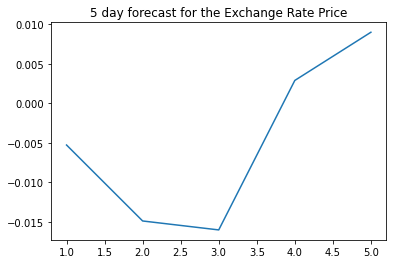

In [50]:
forecast = data.iloc[0,:]
forecast.plot(title = "5 day forecast for the Exchange Rate Price" )

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** I don't think I did the forecast correct, but according to the garph, the price of the Yen should increase in the near term

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [51]:
import arch as arch

In [60]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
res = model.fit(disp="off")

In [61]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17849.0
                                        No. Observations:                 7928
Date:                Tue, May 03 2022   Df Residuals:                     7928
Time:                        12:49:00   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0734e-03  2.401e-03      3.779  1.574e-04 [4.368e-03,1.378e-02]
alpha[1]       0.0624  9.003e-03      6.936  4.036e-12 [4.480e-02,8.009e-02]
beta[1]        0.9243  1.110e-02     83.252      0.000     [  0.903,  0.946]
============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [62]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [63]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [64]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566047,12.573736,12.581319,12.588797,12.596172


In [65]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566047
h.2,12.573736
h.3,12.581319
h.4,12.588797
h.5,12.596172


<AxesSubplot:>

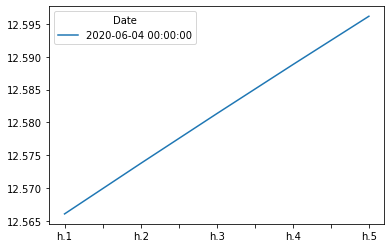

In [66]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** YOUR ANSWER HERE

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * It's hard to say, although the ARMA and ARIMA do show short term gains for the Yen, the models don't have a high p-value and correlation with the actual price and therefore can't be trusted heavily. From an outsiders perspective, there is a clear long term downwards trend and for that reason I wouldn't buy now.

2. Is the risk of the yen expected to increase or decrease?
    * The risk of the yen is expected to increase as the volatility of the Yen is expected to increase, We know the volatility is expected to increase due to the low p -value recieved by the Garch model

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I would feel confident using the garch model but not the other two as they aren't as accurate and don't return great p-values